 1. Import Required Libraries

In [5]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.applications import EfficientNetB0
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

2. Define Constants and Configuration

In [6]:
# Constants
DATA_PATH = r"D:\PROJECT\GAS\DATA"  # Update this path
BRANDS = ['HP', 'IND', 'UNKNOWN']
SIZES = ['2KG', '5KG', '15KG']
COLORS = ['BLUE', 'RED', 'UNKNOWN']

IMG_SIZE = (224, 224)
BATCH_SIZE = 64
EPOCHS = 20
TEST_SIZE = 0.2
MODEL_SAVE_PATH = r"D:\PROJECT\GAS\prefinal1"
os.makedirs(MODEL_SAVE_PATH, exist_ok=True)

# Data Augmentation
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])


3. Load Dataset Function

In [7]:
def load_dataset(data_path):
    image_paths, presence_labels, brand_labels, size_labels, color_labels, absent_labels = [], [], [], [], [], []

    for root, dirs, files in os.walk(data_path):
        for dir_name in dirs:
            folder_path = os.path.join(root, dir_name)
            dir_upper = dir_name.upper()
            is_present = "PRESENT" in dir_upper
            is_absent = "ABSENT" in dir_upper

            if is_present:
                parts = dir_upper.split('_')
                if len(parts) < 4: continue
                brand = parts[0] if parts[0] in BRANDS else 'UNKNOWN'
                size = parts[1] if parts[1] in SIZES else '5KG'
                color = parts[2] if parts[2] in COLORS else 'UNKNOWN'
            elif is_absent:
                brand, size, color = 'UNKNOWN', '15KG', 'UNKNOWN'
            else:
                continue  # skip irrelevant folders

            for file in os.listdir(folder_path):
                if file.lower().endswith(('.jpg', '.jpeg', '.png')):
                    image_paths.append(os.path.join(folder_path, file))
                    presence_labels.append(1 if is_present else 0)
                    brand_labels.append(BRANDS.index(brand))
                    size_labels.append(SIZES.index(size))
                    color_labels.append(COLORS.index(color))
                    absent_labels.append(1 if is_absent else 0)

    return image_paths, presence_labels, brand_labels, size_labels, color_labels, absent_labels

 4. Check Dataset Shapes

In [8]:
image_paths, presence, brand, size, color, absent = load_dataset(DATA_PATH)

print(f"Total images loaded: {len(image_paths)}")
print(f"Absent labels shape: {np.array(absent).shape}")
print(f"Presence labels shape: {np.array(presence).shape}")
print(f"Brand labels shape: {np.array(brand).shape}")
print(f"Size labels shape: {np.array(size).shape}")
print(f"Color labels shape: {np.array(color).shape}")
print(f"Number of Absent images: {np.sum(absent)}")
print(f"Number of Present images: {np.sum(presence)}")


Total images loaded: 17070
Absent labels shape: (17070,)
Presence labels shape: (17070,)
Brand labels shape: (17070,)
Size labels shape: (17070,)
Color labels shape: (17070,)
Number of Absent images: 11
Number of Present images: 17059


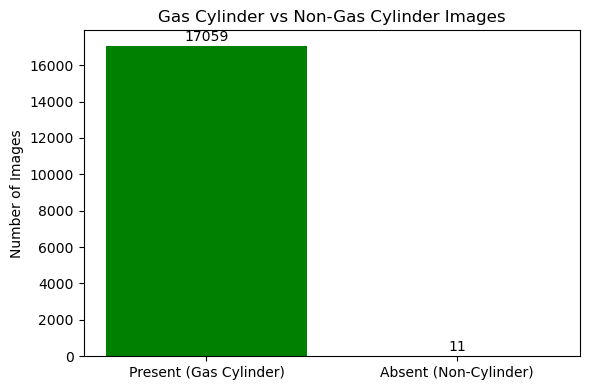

In [9]:
present_count = np.sum(presence)
absent_count = len(presence) - present_count
labels = ['Present (Gas Cylinder)', 'Absent (Non-Cylinder)']
counts = [present_count, absent_count]
plt.figure(figsize=(6, 4))
bars = plt.bar(labels, counts, color=['green', 'red'])
plt.title('Gas Cylinder vs Non-Gas Cylinder Images')
plt.ylabel('Number of Images')
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + 100, int(yval), ha='center', va='bottom')

plt.tight_layout()
plt.show()

5. Image Preprocessing Function

In [10]:
def load_and_preprocess_image(image_path, label=None):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMG_SIZE)
    img = tf.keras.applications.efficientnet.preprocess_input(img)
    return (img, label) if label is not None else img

6. Build the Presence Model

In [11]:
def create_presence_model():
    base = EfficientNetB0(include_top=False, weights='imagenet', input_shape=(*IMG_SIZE, 3), pooling='avg')
    base.trainable = False
    inputs = tf.keras.Input(shape=(*IMG_SIZE, 3))
    x = data_augmentation(inputs)
    x = base(x)
    x = layers.Dense(64, activation='relu')(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)
    model = tf.keras.Model(inputs, outputs)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model


 7. Build the Attribute Model

In [12]:
def create_attribute_model():
    base = EfficientNetB0(include_top=False, weights='imagenet', input_shape=(*IMG_SIZE, 3), pooling='avg')
    base.trainable = False
    inputs = tf.keras.Input(shape=(*IMG_SIZE, 3))
    x = data_augmentation(inputs)
    x = base(x)
    brand_out = layers.Dense(len(BRANDS), activation='softmax', name='brand')(x)
    size_out = layers.Dense(len(SIZES), activation='softmax', name='size')(x)
    color_out = layers.Dense(len(COLORS), activation='softmax', name='color')(x)
    model = tf.keras.Model(inputs, [brand_out, size_out, color_out])
    model.compile(
        optimizer='adam',
        loss={
            'brand': 'sparse_categorical_crossentropy',
            'size': 'sparse_categorical_crossentropy',
            'color': 'sparse_categorical_crossentropy'
        },
        metrics={
            'brand': 'accuracy',
            'size': 'accuracy',
            'color': 'accuracy'
        }
    )
    return model

 8. Training Class

In [13]:
class CylinderClassifier:
    def __init__(self):
        self.presence_model = create_presence_model()
        self.attribute_model = create_attribute_model()
        self.callbacks = [
            callbacks.EarlyStopping(patience=5, restore_best_weights=True),
            callbacks.ModelCheckpoint(os.path.join(MODEL_SAVE_PATH, 'best_model.keras'), save_best_only=True)
        ]

    def train_and_evaluate(self, image_paths, presence, brand, size, color):
        (train_paths, test_paths,
         train_pres, test_pres,
         train_brand, test_brand,
         train_size, test_size,
         train_color, test_color) = train_test_split(
            image_paths, presence, brand, size, color, test_size=TEST_SIZE, random_state=42)

        def make_dataset(paths, labels, is_attr=False):
            if is_attr:
                ds = tf.data.Dataset.from_tensor_slices((paths, labels))
                ds = ds.map(lambda x, y: (load_and_preprocess_image(x), {
                    'brand': y[0], 'size': y[1], 'color': y[2]
                }), num_parallel_calls=tf.data.AUTOTUNE)
            else:
                ds = tf.data.Dataset.from_tensor_slices((paths, labels))
                ds = ds.map(lambda x, y: (load_and_preprocess_image(x), y), num_parallel_calls=tf.data.AUTOTUNE)
            return ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

        # Prepare datasets
        presence_train_ds = make_dataset(train_paths, train_pres)
        presence_test_ds = make_dataset(test_paths, test_pres)

        attr_train_labels = np.stack([train_brand, train_size, train_color], axis=1)
        attr_test_labels = np.stack([test_brand, test_size, test_color], axis=1)
        attr_train_ds = make_dataset(train_paths, attr_train_labels, is_attr=True)
        attr_test_ds = make_dataset(test_paths, attr_test_labels, is_attr=True)

        # Train models
        print("Training presence model...")
        presence_history = self.presence_model.fit(
            presence_train_ds, validation_data=presence_test_ds,
            epochs=EPOCHS, callbacks=self.callbacks, verbose=1
        )

        print("\nTraining attribute model...")
        attr_history = self.attribute_model.fit(
            attr_train_ds, validation_data=attr_test_ds,
            epochs=EPOCHS, callbacks=self.callbacks, verbose=1
        )

        self.presence_history = presence_history
        self.attr_history = attr_history
        
        # Save models
        self.presence_model.save(os.path.join(MODEL_SAVE_PATH, 'presence_final.keras'))
        self.attribute_model.save(os.path.join(MODEL_SAVE_PATH, 'attribute_final.keras'))
        print("\nTraining complete! Models saved.")

 9. Train the Model

In [14]:
classifier = CylinderClassifier()
classifier.train_and_evaluate(image_paths, presence, brand, size, color)

Training presence model...
Epoch 1/20
214/214 ━━━━━━━━━━━━━━━━━━━━ 513s 2s/step - accuracy: 0.9954 - loss: 0.0300 - val_accuracy: 0.9991 - val_loss: 0.0021
Epoch 2/20
214/214 ━━━━━━━━━━━━━━━━━━━━ 503s 2s/step - accuracy: 0.9999 - loss: 1.6325e-04 - val_accuracy: 0.9994 - val_loss: 8.9775e-04
Epoch 3/20
214/214 ━━━━━━━━━━━━━━━━━━━━ 504s 2s/step - accuracy: 1.0000 - loss: 3.6057e-05 - val_accuracy: 0.9994 - val_loss: 8.1446e-04
Epoch 4/20
214/214 ━━━━━━━━━━━━━━━━━━━━ 502s 2s/step - accuracy: 1.0000 - loss: 1.9251e-05 - val_accuracy: 0.9994 - val_loss: 7.3688e-04
Epoch 5/20
214/214 ━━━━━━━━━━━━━━━━━━━━ 503s 2s/step - accuracy: 1.0000 - loss: 9.6235e-06 - val_accuracy: 0.9994 - val_loss: 7.5941e-04
Epoch 6/20
214/214 ━━━━━━━━━━━━━━━━━━━━ 522s 2s/step - accuracy: 1.0000 - loss: 6.7291e-06 - val_accuracy: 0.9997 - val_loss: 6.0261e-04
Epoch 7/20
214/214 ━━━━━━━━━━━━━━━━━━━━ 514s 2s/step - accuracy: 1.0000 - loss: 4.3841e-06 - val_accuracy: 0.9997 - val_loss: 5.8311e-04
Epoch 8/20
214/214 ━━━

In [6]:
#THIS IS TEST CODE
import os
import tensorflow as tf
import numpy as np

# Constants
TEST_FOLDER = r"D:\PROJECT\GAS\test"  #TEST FOLDER PATH 
#PATH TO LOAD MODEL
PRESENCE_MODEL_PATH = r"D:\PROJECT\GAS\prefinal1\presence_final.keras"     #
ATTRIBUTE_MODEL_PATH = r"D:\PROJECT\GAS\prefinal1\attribute_final.keras"
IMG_SIZE = (224, 224)

# Class labels
BRANDS = ['HP', 'IND', 'UNKNOWN']
SIZES = ['2KG', '5KG', '15KG']
COLORS = ['BLUE', 'RED', 'UNKNOWN']

# Load models
print("Loading models...")
presence_model = tf.keras.models.load_model(PRESENCE_MODEL_PATH)
attribute_model = tf.keras.models.load_model(ATTRIBUTE_MODEL_PATH)

# Preprocessing function
def preprocess_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMG_SIZE)
    img = tf.keras.applications.efficientnet.preprocess_input(img)
    return tf.expand_dims(img, axis=0)

# Predict function
def predict_image(image_path):
    img_tensor = preprocess_image(image_path)
    presence_pred = presence_model.predict(img_tensor, verbose=0)[0][0]
    
    if presence_pred < 0.5:
        return "Absent", None, None, None
    else:
        brand_pred, size_pred, color_pred = attribute_model.predict(img_tensor, verbose=0)
        brand = BRANDS[np.argmax(brand_pred)]
        size = SIZES[np.argmax(size_pred)]
        color = COLORS[np.argmax(color_pred)]
        return "Cylinder Present", brand, size, color

# Run predictions on folder
print("\n--- Predictions ---\n")
for filename in os.listdir(TEST_FOLDER):
    if filename.lower().endswith(('.jpg', '.jpeg', '.png')):
        image_path = os.path.join(TEST_FOLDER, filename)
        presence, brand, size, color = predict_image(image_path)

        print(f"File: {filename}")
        print(f"  Presence: {presence}")
        if presence == "Cylinder Present":
            print(f"  Brand: {brand}")
            print(f"  Size: {size}")
            print(f"  Color: {color}")
        print()


Loading models...

--- Predictions ---

File: 1.jpg
  Presence: Absent

File: 10.jpg
  Presence: Absent

File: 2.jpg
  Presence: Absent

File: 20-litre-water-jug.jpg
  Presence: Absent

File: 3.jpg
  Presence: Absent

File: 4.jpg
  Presence: Absent

File: 5.jpg
  Presence: Absent

File: 6.jpg
  Presence: Absent

File: 7.jpg
  Presence: Cylinder Present
  Brand: IND
  Size: 15KG
  Color: BLUE

File: 8.jpg
  Presence: Absent

File: 9.jpg
  Presence: Absent

File: HP_15KG_RED_frame_00001.jpg
  Presence: Cylinder Present
  Brand: HP
  Size: 15KG
  Color: RED

File: HP_15KG_RED_frame_00543.jpg
  Presence: Cylinder Present
  Brand: HP
  Size: 15KG
  Color: RED

File: HP_15KG_RED_frame_01115.jpg
  Presence: Cylinder Present
  Brand: HP
  Size: 15KG
  Color: RED

File: HP_15KG_RED_frame_01149.jpg
  Presence: Cylinder Present
  Brand: HP
  Size: 15KG
  Color: RED

File: HP_15KG_RED_frame_01210.jpg
  Presence: Cylinder Present
  Brand: HP
  Size: 15KG
  Color: RED

File: HP_15KG_RED_frame_01251.